In [1]:
import numpy as np
from skimage.data import shepp_logan_phantom
import matplotlib.pyplot as plt
from tqdm import tqdm

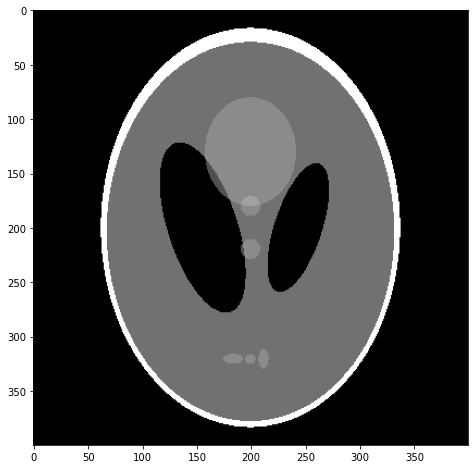

In [2]:
# create a phantom and k-space data (ground truth)
plt.figure(1, figsize=(8, 8))
P = shepp_logan_phantom()
plt.imshow(abs(P)**0.5, cmap='gray', aspect='equal')
plt.show()

### Its a 400x400 image in Python skimage, not 256x256 as given in the MATLAB code.

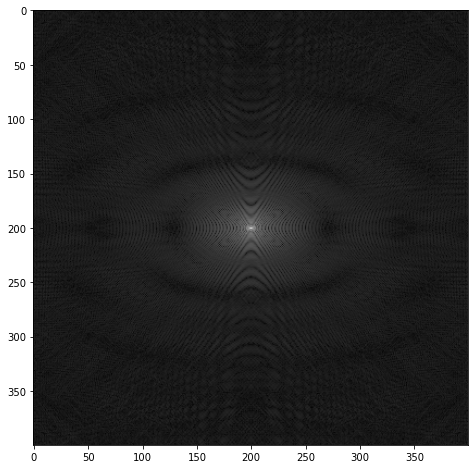

In [3]:
kSpaceData = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(P)))
plt.figure(2, figsize=(8, 8))
plt.imshow(abs(kSpaceData)**0.3, cmap='gray', aspect='equal')
plt.show()

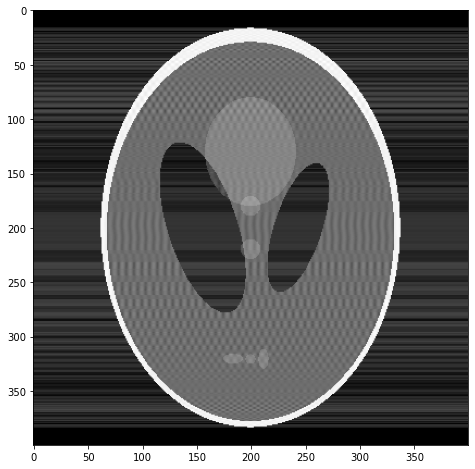

In [4]:
# simulate a case where part of the k-space data is corrupted
kSpaceData_corrupted = kSpaceData.copy()
kSpaceData_corrupted[:,256] = kSpaceData[:,256]*10                   # The matlab code has 180th line corrupted but here we choose the 256th line as corruption.
P_corrupted = np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(kSpaceData_corrupted)))
plt.figure(3, figsize=(8, 8))
plt.imshow(abs(P_corrupted)**0.5, cmap='gray', aspect='equal')
plt.show()

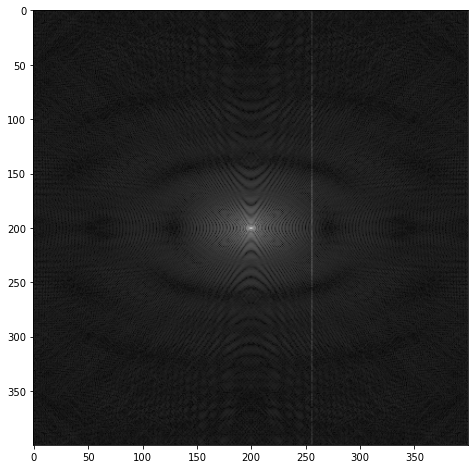

In [5]:
plt.figure(4, figsize=(8, 8))
plt.imshow(abs(kSpaceData_corrupted)**0.3, cmap='gray', aspect='equal')
plt.show()

In [6]:
# assuming that we know that line#180 of the k-space data is corrupted but don't know the correct value. 
# We will use an iterative approach to produce an image with reduced artifact

In [7]:
# # Step 1:
# corruped_image = P_corrupted.copy()
# corruped_image_fixed = corruped_image.copy()
# corruped_image_fixed[:,np.r_[0:32,-31:0]] = 0

# plt.figure(5, figsize=(8, 8))
# plt.imshow(abs(corruped_image_fixed)**0.5, cmap='gray', aspect='equal')
# plt.show()

In [8]:
# corrupted_kdata_fixed = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(corruped_image_fixed)))
# plt.figure(6, figsize=(8, 8))
# plt.imshow(abs(corrupted_kdata_fixed)**0.3, cmap='gray', aspect='equal')
# plt.show()

In [9]:
# # Step 2:
# corrupted_kdata_fixed_again = kSpaceData_corrupted.copy()
# corrupted_kdata_fixed_again[:,256] = corrupted_kdata_fixed[:,256]
# corruped_image_fixed_again = np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(corrupted_kdata_fixed_again)))
# plt.figure(7, figsize=(8, 8))
# plt.imshow(abs(corruped_image_fixed_again)**0.5, cmap='gray', aspect='equal')
# plt.show()

In [10]:
# plt.figure(8, figsize=(8, 8))
# plt.imshow(abs(corrupted_kdata_fixed_again)**0.3, cmap='gray', aspect='equal')
# plt.show()

In [11]:
# # check:
# plt.figure(13, figsize=(16, 9))
# plt.plot(range(400), abs(kSpaceData_corrupted[:,256]), "g",range(400), abs(corrupted_kdata_fixed_again[:,256]), "r",range(400), abs(kSpaceData[:,256]), "k")
# plt.legend(['k-space Corrupted ','k-space Fixed Once','k-space clean'], prop = { "size": 20 })
# plt.show()

In [ ]:
# Directly go to iterative reconstruction

## Residual Computation


In [54]:
steps = 100
residuals = np.zeros(steps)
for cnt in tqdm(range(steps)):
    # Step 1a:
    if cnt == 0:
        corruped_image = P_corrupted.copy()
    else:
        corruped_image = corruped_image_fixed_again.copy()
    corruped_image_fixed = corruped_image.copy()
    corruped_image_fixed[:,np.r_[0:32,-31:0]] = 0
    corrupted_kdata_fixed = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(corruped_image_fixed)))
    # Step 2a:
    corrupted_kdata_fixed_again = kSpaceData_corrupted.copy()
    corrupted_kdata_fixed_again[:,256] = corrupted_kdata_fixed[:,256]
    corruped_image_fixed_again = np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(corrupted_kdata_fixed_again)))
    
    ####################### residual calculation
    residual = np.sum(np.abs(kSpaceData)) - np.sum(np.abs(corruped_image_fixed_again))
    residuals[cnt] = residual

100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 96.67it/s]


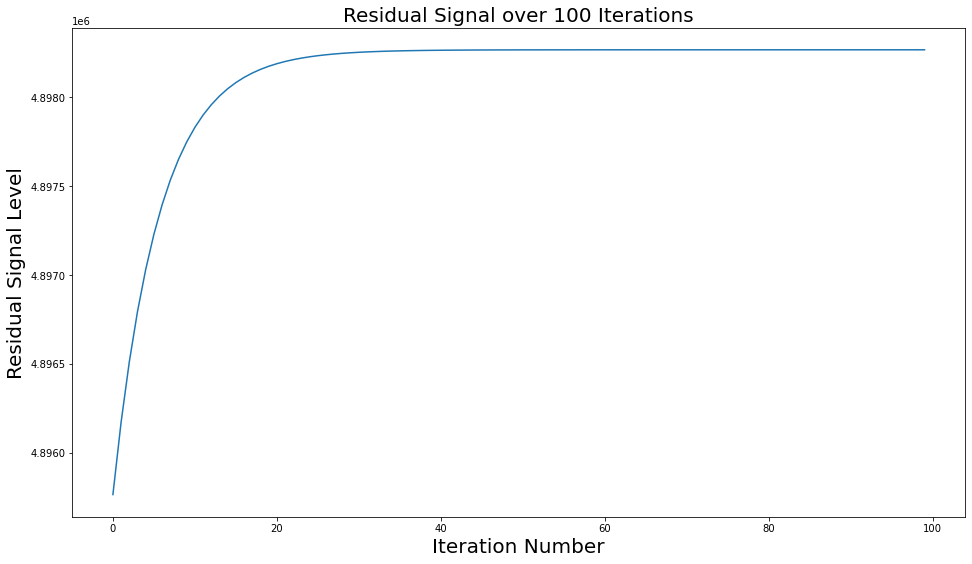

In [55]:
plt.figure(figsize=(16, 9))
plt.plot(range(steps), residuals)
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Iteration Number', fontsize= 20)
plt.ylabel('Residual Signal Level', fontsize= 20)
plt.title(f'Residual Signal over {steps} Iterations', fontsize= 20 )
plt.show()

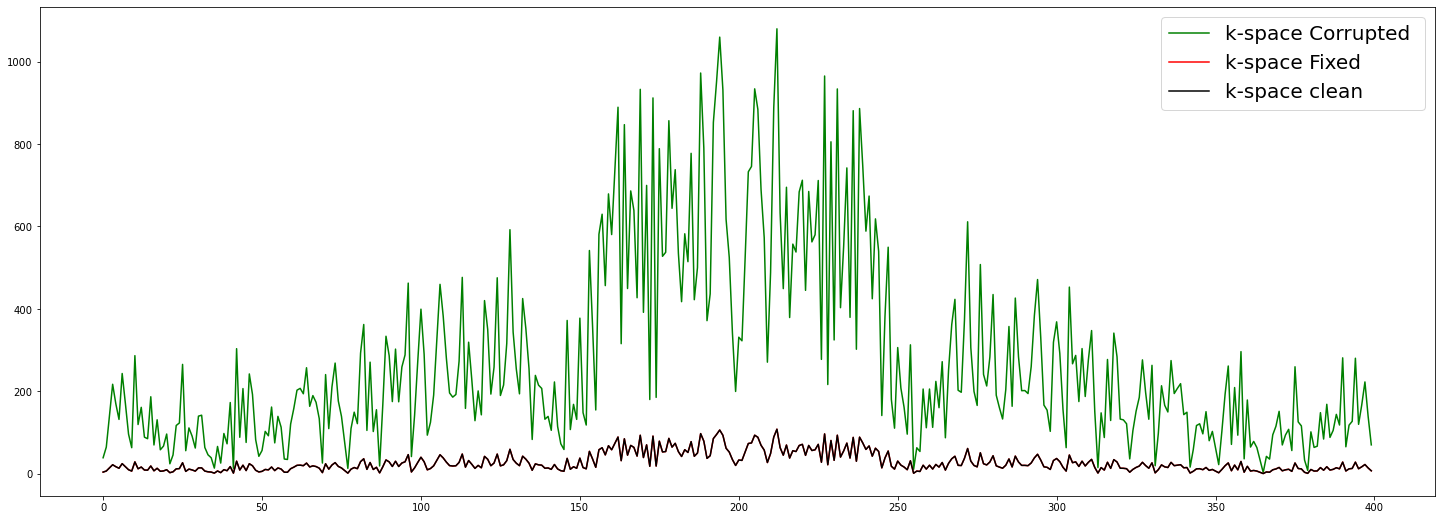

In [57]:
### check
# check:
plt.figure(13, figsize=(25, 9))
plt.plot(range(400), abs(kSpaceData_corrupted[:,256]), "g", range(400), abs(corrupted_kdata_fixed_again[:,256]), "r", range(400), abs(kSpaceData[:,256]), "k")
plt.legend(['k-space Corrupted ',f'k-space Fixed','k-space clean'], prop = { "size": 20 })
plt.show()

# Thresold Stopping with stopping criterion

In [62]:
steps = 1000
residuals = []
# res_per = np.zeros(steps)

# Define the threshold for change in residual artifact
threshold = 1e-7

# Define initial residual artifact value
prev_res_artifact = 1e-9


for cnt in tqdm(range(steps)):
    # Step 1a:
    if cnt == 0:
        corruped_image = P_corrupted.copy()
    else:
        corruped_image = corruped_image_fixed_again.copy()
    corruped_image_fixed = corruped_image.copy()
    corruped_image_fixed[:,np.r_[0:32,-31:0]] = 0
    corrupted_kdata_fixed = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(corruped_image_fixed)))
    # Step 2a:
    corrupted_kdata_fixed_again = kSpaceData_corrupted.copy()
    corrupted_kdata_fixed_again[:,256] = corrupted_kdata_fixed[:,256]
    corruped_image_fixed_again = np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(corrupted_kdata_fixed_again)))
    
    ####################### residual calculation
    residual = np.sum(np.abs(kSpaceData)) - np.sum(np.abs(corruped_image_fixed_again))
    residuals.append(residual)
    
    
    # Check if the change in residual artifact is below threshold
    
    res_per = (residual - prev_res_artifact) / prev_res_artifact
    
    
    if np.abs(residual - prev_res_artifact) / prev_res_artifact < threshold:
        print(f'Early Stopping... thresold reached at step {cnt}')
        stop_count = cnt
        break
    
    # # Update the previous residual artifact and iteration counter
    prev_res_artifact = residual
    
    # print(res_per)

  4%|█▋                                       | 40/1000 [00:00<00:10, 89.95it/s]

Early Stopping... thresold reached at step 40


## Residual Plots

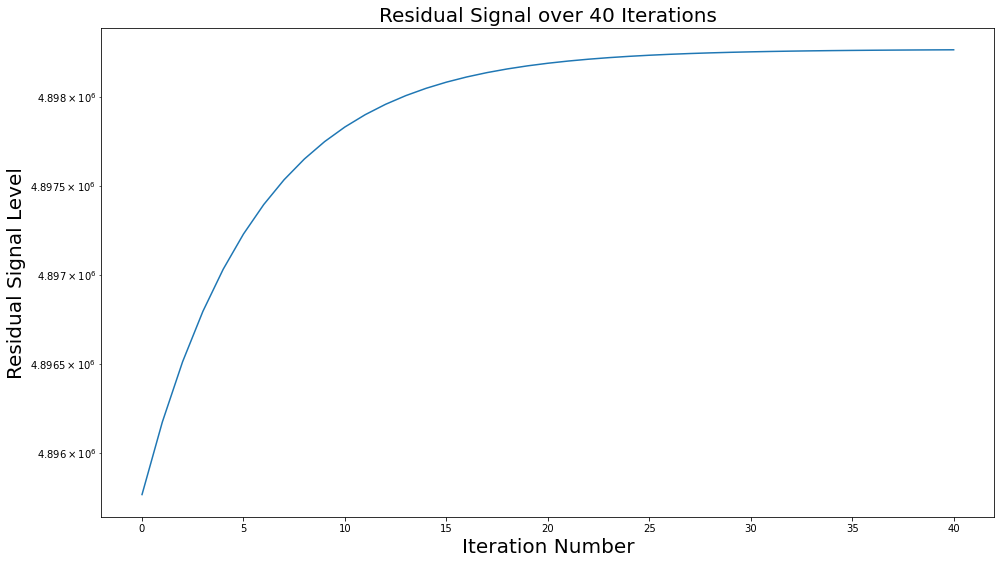

In [67]:
plt.figure(figsize=(16, 9))
plt.plot(range(len(residuals)), residuals)
# plt.xscale('log')
plt.yscale('log')
plt.xlabel('Iteration Number', fontsize= 20)
plt.ylabel('Residual Signal Level', fontsize= 20)
plt.title(f'Residual Signal over {stop_count} Iterations', fontsize= 20 )
plt.show()

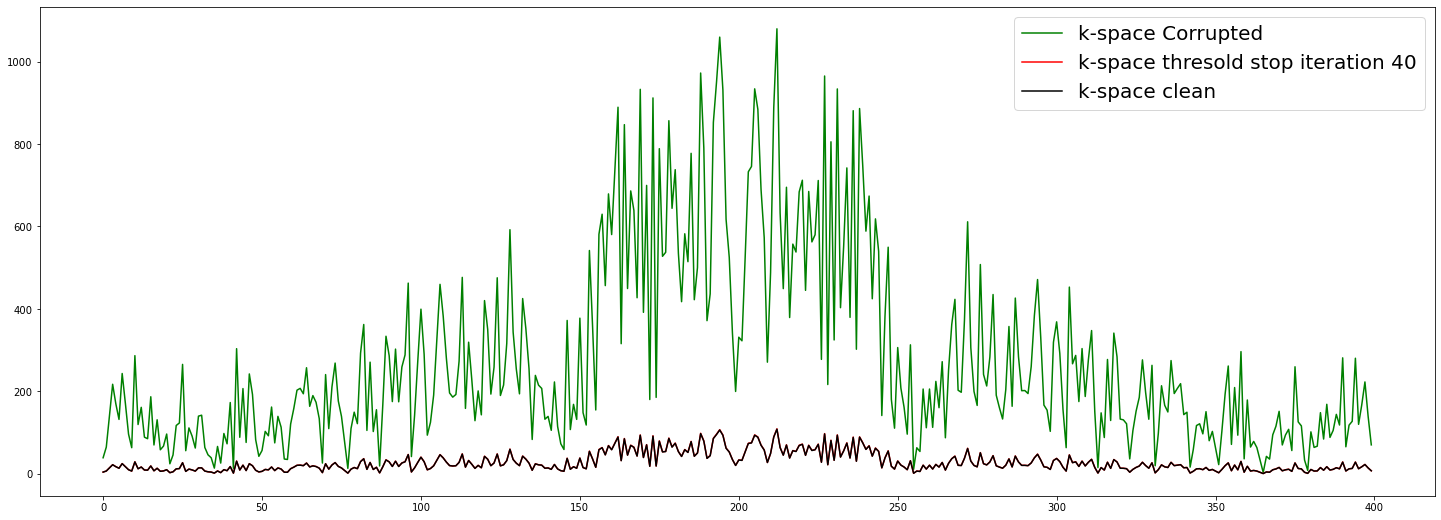

In [64]:
### check
# check:
plt.figure(13, figsize=(25, 9))
plt.plot(range(400), abs(kSpaceData_corrupted[:,256]), "g", range(400), abs(corrupted_kdata_fixed_again[:,256]), "r", range(400), abs(kSpaceData[:,256]), "k")
plt.legend(['k-space Corrupted ',f'k-space thresold stop iteration {stop_count}','k-space clean'], prop = { "size": 20 })
plt.show()

## looks good -- the k-data are getting very close to the ground truth

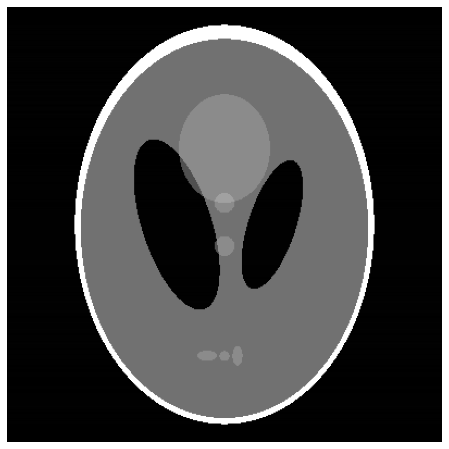

In [65]:
plt.figure(13, figsize=(8, 8))
plt.imshow(abs(corruped_image_fixed_again) ** 0.5, cmap="gray")
plt.axis("off")
plt.show()

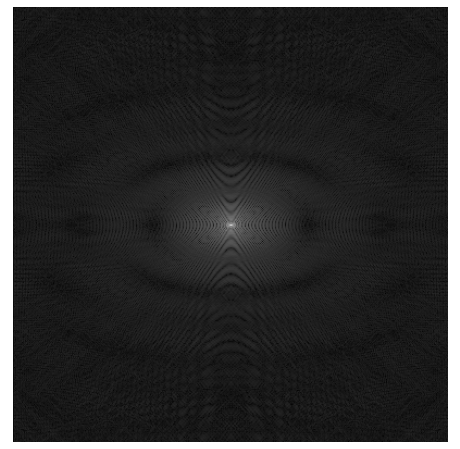

In [66]:
plt.figure(14, figsize=(8, 8))
plt.imshow(abs(corrupted_kdata_fixed_again) ** 0.3, cmap="gray")
plt.axis("equal")
plt.axis("off")
plt.show()